In [1]:
import datetime
import numpy as np
import pickle as pkl
import pandas as pd
pd.options.display.max_columns = 999
pd.options.display.max_rows = 999

# import matplotlib
# matplotlib.use('TkAgg')
import matplotlib.pyplot as plt

%matplotlib inline
from matplotlib import pyplot as plt
%pylab inline


Populating the interactive namespace from numpy and matplotlib


### simulate data:
__Assume__: 
- there are sensor data from 3 Regulators and 5 Syphons for 2 weeks, with 10 minutes gap
- the normal curve shape is sinusoidal like in the range of 1.75 kpa to 2.25 kpa, the peak happens in the evening
- any points which are too much deviated from the normal curve shape will be considered as anomaly

In [7]:
import random


def simulate_base_daily(gap=10, peaktime=(18, 30, 0), strt_tm=datetime.datetime(2019, 1, 1, 0, 0, 0), plot_=False):
    """
    :param gap: in minute
    :param peaktime: in form of (hour, minute, second)
    :return:
    """
    nts = int(24*60/gap)
    period = np.arange(0, 2*np.pi, 2*np.pi / (nts))
    amp = np.sin(period) / 4 + 2

    df = pd.DataFrame({'pressure': amp, 'ts': 0})
    peak_ind = df[df['pressure'] == df['pressure'].max()].index[0]
    peak_time = datetime.datetime(strt_tm.year, strt_tm.month, strt_tm.day, peaktime[0], peaktime[1], peaktime[2])
    gap_time = datetime.timedelta(seconds=60*gap)
    df.loc[df.index == peak_ind, 'ts'] = peak_time
    df.loc[df.index < peak_ind, 'ts'] = [peak_time-gap_time*i for i in range(1, peak_ind+1)][::-1]
    df.loc[df.index > peak_ind, 'ts'] = [peak_time+gap_time*i for i in range(1, len(df)-peak_ind)]
    df['time'] = df['ts'].apply(lambda x: x.hour*60 + x.minute)

    df2 = pd.DataFrame({'ts': [strt_tm + gap_time * i for i in range(nts)]})
    df2['time'] = df2['ts'].apply(lambda x: x.hour*60 + x.minute)
    df2 = df2.merge(df[['time', 'pressure']], how='left', on='time')

    if plot_:
        plt.plot(df2['time'], df2['pressure'])
        plt.show()
    return df2[['ts', 'pressure']]


def generate_normal_curve(strt_tm=datetime.datetime(2019, 1, 1, 0, 0, 0), duration=datetime.timedelta(days=14),
                          gap=10, peaktime=(18, 30, 0), random_range=0.2, plot_=False):
    base_daily = simulate_base_daily(gap, peaktime, strt_tm, plot_=False)['pressure'].tolist()
    gap_time = datetime.timedelta(seconds=60*gap)
    nts = int(duration / gap_time)
    df = pd.DataFrame({'ts': [strt_tm + gap_time * i for i in range(nts)], 'pressure': base_daily*duration.days})
    val_range = df['pressure'].max() - df['pressure'].min()
    df['noise'] = [random.uniform(-val_range*random_range/2, val_range*random_range/2) for i in range(len(df))]
    df['pressure_normal'] = df['pressure'] + df['noise']
    if plot_:
        plt.plot_date(df['ts'], df['pressure_normal'], linewidth=0.5, linestyle='-', marker='')
        plt.show()
    return df


def add_anomaly(df, anomaly_pct=0.1, anomaly_range=(0.4, 0.8), plot_=False):
    val_range = df['pressure'].max() - df['pressure'].min()
    anomaly_noise = [random.uniform(val_range*anomaly_range[0], val_range*anomaly_range[1]) * 
                     random.sample([-1,1], 1)[0]
                     for i in range(int(len(df)*anomaly_pct))]
    anomaly_noise += [0]*(len(df) - len(anomaly_noise))
    random.shuffle(anomaly_noise)
    len(anomaly_noise)
    df['anomaly_noise'] = anomaly_noise
    df['pressure_abnormal'] = df['anomaly_noise'] + df['pressure_normal']
    df['anomly_flag'] = 0
    df.loc[df['anomaly_noise'] != 0, 'anomly_flag'] = 1
    if plot_:
        plt.figure(figsize=(18, 5))
        plt.plot_date(df['ts'], df['pressure_abnormal'], linewidth=0.5, linestyle='-', marker='', color='green')
        tmp = df[df['anomly_flag'] == 1]
        plt.plot_date(tmp['ts'], tmp['pressure_abnormal'], linewidth=0.5, linestyle='', marker='.', color='red', markersize=3)
        plt.show()
    return df

def flatline_anomaly(df, const=(0, 1.2), straight=False, anomaly_pct=0.05, min_dur_ts=10, plot_=True, gap=10):
    mode = []    
    if straight:  # remove the data in between and connect with straight line
        mode += ['straight']
    if const is not None:  # set the data in between to be const
        mode += ['constant']    
        
    max_dur_ts = int(len(df)*anomaly_pct)
    all_ts = list(df['ts'])
    dur_ts_list = []
    cumu_dur = 0

    while (cumu_dur < max_dur_ts) & (max_dur_ts - cumu_dur >= min_dur_ts):
        dur = random.randint(min_dur_ts, max_dur_ts - cumu_dur)
        strt = random.sample(all_ts, 1)[0]
        print(strt, dur)
        dur_ts_list.append([strt, dur])
        cumu_dur += dur

    for dl in dur_ts_list:
        strt, dur = dl
        end = strt + datetime.timedelta(seconds=60*dur*gap)
        md = random.sample(mode, 1)[0]
        if md == 'constant':
            df.loc[(df['ts'] >= strt) & (df['ts'] <= end), 'pressure_abnormal'] = random.uniform(const[0], const[1])
        elif md == 'straight':
            df.loc[(df['ts'] >= strt) & (df['ts'] <= end), 'pressure_abnormal'] == np.nan
            df['pressure_abnormal'] = df['pressure_abnormal'].interpolate(method='linear')
        df.loc[(df['ts'] >= strt) & (df['ts'] <= end), 'anomly_flag'] = 1        
        
    if plot_:
        plt.figure(figsize=(18, 5))
        plt.plot_date(df['ts'], df['pressure_abnormal'], linewidth=0.5, linestyle='-', marker='', color='green')
        tmp = df[df['anomly_flag'] == 1]
        plt.plot_date(tmp['ts'], tmp['pressure_abnormal'], linewidth=0.5, linestyle='', marker='.', color='red', markersize=3)
        plt.show()

    return df
 

======= add single point anomaly =============


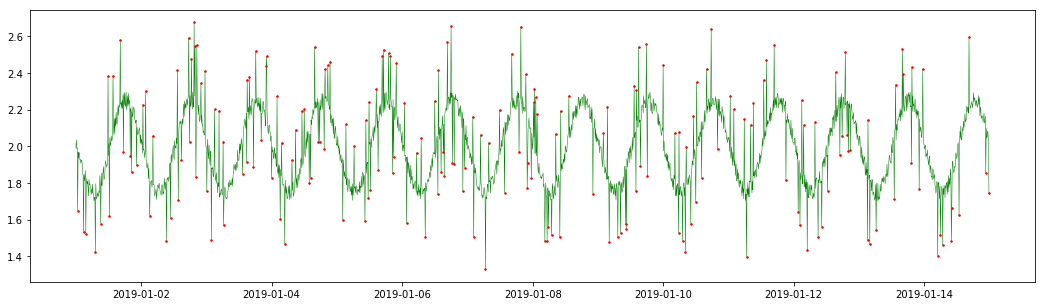

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,-0.037669,1.994962,0.000000,1.994962,0
1,2019-01-01 00:10:00,2.021789,0.014359,2.036148,0.000000,2.036148,0
2,2019-01-01 00:20:00,2.010905,-0.022862,1.988043,0.000000,1.988043,0
3,2019-01-01 00:30:00,2.000000,-0.006996,1.993004,0.000000,1.993004,0
4,2019-01-01 00:40:00,1.989095,0.018922,2.008017,-0.358076,1.649941,1


======= add connected anomaly =============
2019-01-13 20:30:00 16


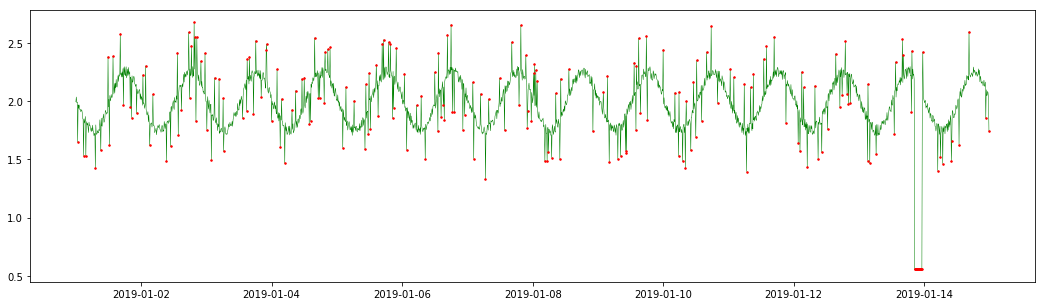

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,-0.037669,1.994962,0.000000,1.994962,0
1,2019-01-01 00:10:00,2.021789,0.014359,2.036148,0.000000,2.036148,0
2,2019-01-01 00:20:00,2.010905,-0.022862,1.988043,0.000000,1.988043,0
3,2019-01-01 00:30:00,2.000000,-0.006996,1.993004,0.000000,1.993004,0
4,2019-01-01 00:40:00,1.989095,0.018922,2.008017,-0.358076,1.649941,1


In [8]:
# test functions
df = generate_normal_curve()
print('======= add single point anomaly =============')
df = add_anomaly(df, plot_=True)
display(df.head())
print('======= add connected anomaly =============')
df = flatline_anomaly(df, const=(0, 1.2), straight=False, anomaly_pct=0.01, min_dur_ts=10, plot_=True)
display(df.head())

============== reg_0 ==============
2019-01-11 09:10:00 13


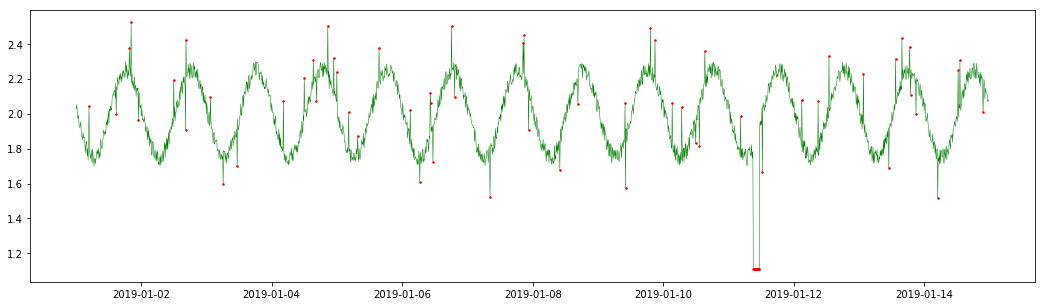

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.001286,2.033917,0.0,2.033917,0
1,2019-01-01 00:10:00,2.021789,0.005541,2.027330,0.0,2.027330,0
2,2019-01-01 00:20:00,2.010905,0.040509,2.051414,0.0,2.051414,0
3,2019-01-01 00:30:00,2.000000,0.024698,2.024698,0.0,2.024698,0
4,2019-01-01 00:40:00,1.989095,-0.014589,1.974506,0.0,1.974506,0


============== reg_1 ==============
2019-01-10 15:50:00 19


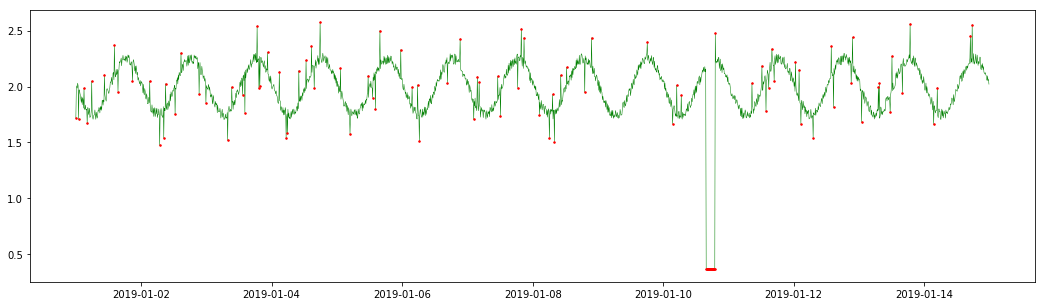

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,-0.046867,1.985764,-0.265209,1.720556,1
1,2019-01-01 00:10:00,2.021789,-0.043107,1.978682,0.000000,1.978682,0
2,2019-01-01 00:20:00,2.010905,-0.004322,2.006583,0.000000,2.006583,0
3,2019-01-01 00:30:00,2.000000,-0.013584,1.986416,0.000000,1.986416,0
4,2019-01-01 00:40:00,1.989095,0.041396,2.030492,0.000000,2.030492,0


============== reg_2 ==============
2019-01-14 05:00:00 17


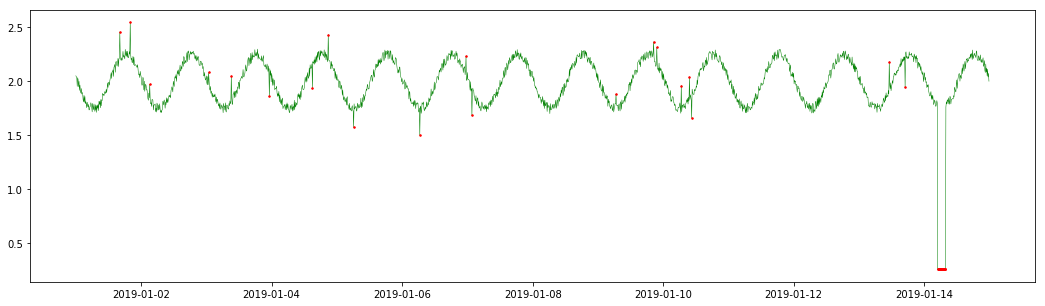

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.019067,2.051699,0.0,2.051699,0
1,2019-01-01 00:10:00,2.021789,0.020583,2.042371,0.0,2.042371,0
2,2019-01-01 00:20:00,2.010905,0.026707,2.037612,0.0,2.037612,0
3,2019-01-01 00:30:00,2.000000,-0.046772,1.953228,0.0,1.953228,0
4,2019-01-01 00:40:00,1.989095,0.044918,2.034013,0.0,2.034013,0


============== syph_0 ==============
2019-01-06 05:20:00 19


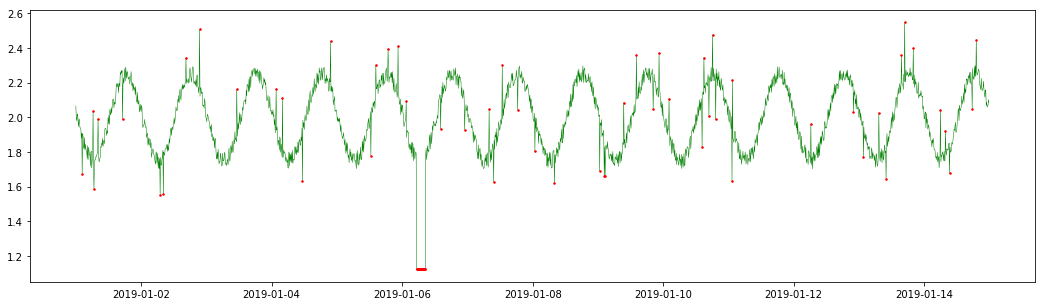

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.033034,2.065665,0.0,2.065665,0
1,2019-01-01 00:10:00,2.021789,-0.027611,1.994178,0.0,1.994178,0
2,2019-01-01 00:20:00,2.010905,-0.031040,1.979865,0.0,1.979865,0
3,2019-01-01 00:30:00,2.000000,0.018311,2.018311,0.0,2.018311,0
4,2019-01-01 00:40:00,1.989095,0.029869,2.018964,0.0,2.018964,0


============== syph_1 ==============
2019-01-01 16:20:00 14


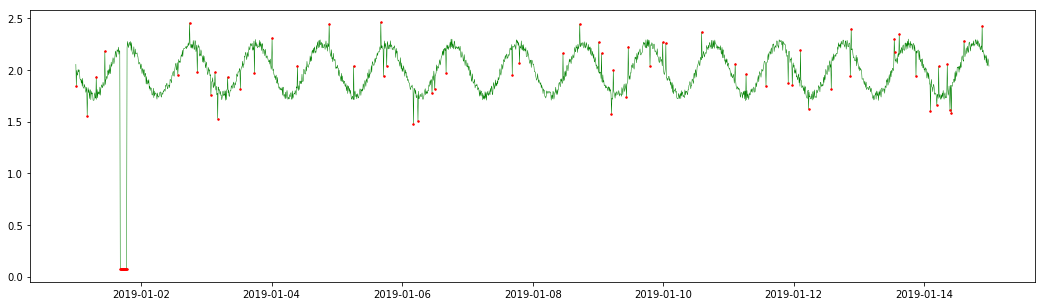

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.020684,2.053316,0.000000,2.053316,0
1,2019-01-01 00:10:00,2.021789,-0.010286,2.011503,-0.164442,1.847060,1
2,2019-01-01 00:20:00,2.010905,-0.016473,1.994432,0.000000,1.994432,0
3,2019-01-01 00:30:00,2.000000,-0.042253,1.957747,0.000000,1.957747,0
4,2019-01-01 00:40:00,1.989095,-0.040816,1.948280,0.000000,1.948280,0


============== syph_2 ==============
2019-01-08 19:40:00 10
2019-01-09 06:00:00 10


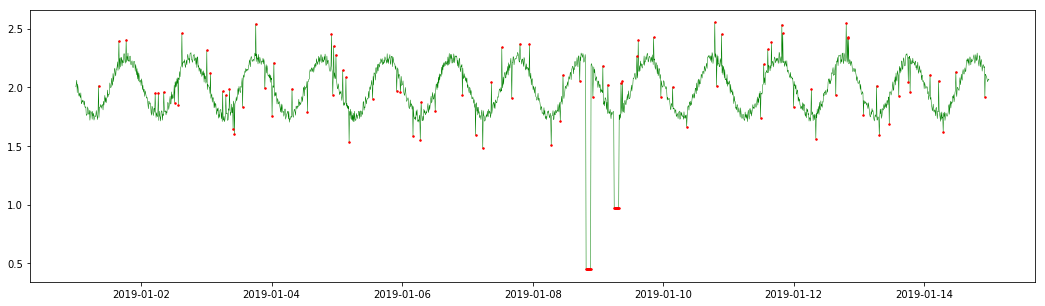

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,-0.029498,2.003134,0.0,2.003134,0
1,2019-01-01 00:10:00,2.021789,0.012751,2.034540,0.0,2.034540,0
2,2019-01-01 00:20:00,2.010905,0.048660,2.059565,0.0,2.059565,0
3,2019-01-01 00:30:00,2.000000,-0.047062,1.952938,0.0,1.952938,0
4,2019-01-01 00:40:00,1.989095,0.037348,2.026443,0.0,2.026443,0


============== syph_3 ==============
2019-01-04 23:00:00 11


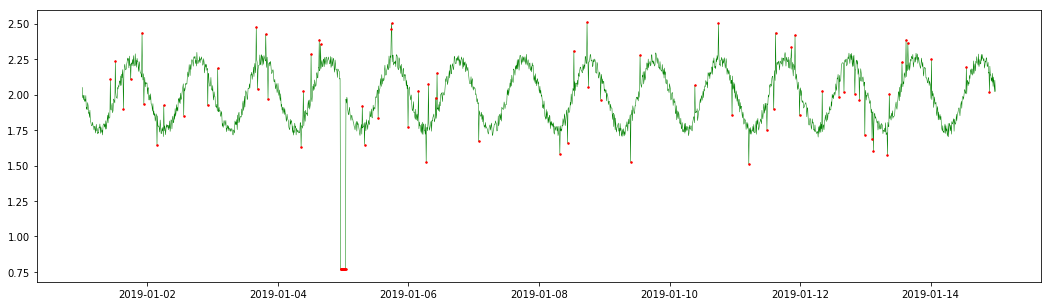

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.018031,2.050663,0.0,2.050663,0
1,2019-01-01 00:10:00,2.021789,-0.043197,1.978591,0.0,1.978591,0
2,2019-01-01 00:20:00,2.010905,-0.014092,1.996813,0.0,1.996813,0
3,2019-01-01 00:30:00,2.000000,-0.035631,1.964369,0.0,1.964369,0
4,2019-01-01 00:40:00,1.989095,0.006625,1.995720,0.0,1.995720,0


============== syph_4 ==============
2019-01-11 14:10:00 17


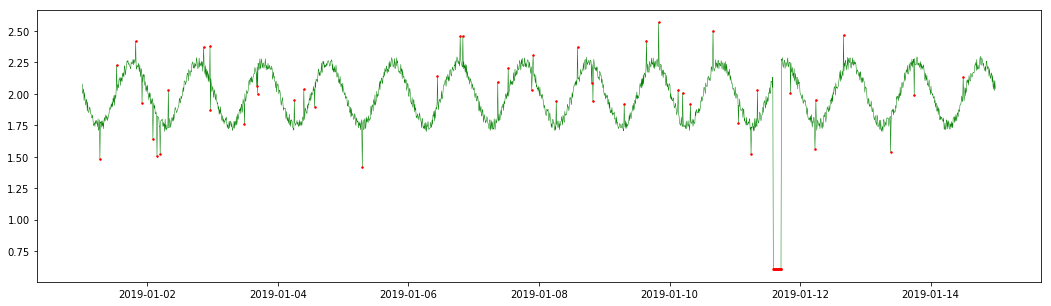

,ts,pressure,noise,pressure_normal,anomaly_noise,pressure_abnormal,anomly_flag
0,2019-01-01 00:00:00,2.032632,0.045841,2.078472,0.0,2.078472,0
1,2019-01-01 00:10:00,2.021789,-0.019240,2.002549,0.0,2.002549,0
2,2019-01-01 00:20:00,2.010905,0.010882,2.021787,0.0,2.021787,0
3,2019-01-01 00:30:00,2.000000,0.040286,2.040286,0.0,2.040286,0
4,2019-01-01 00:40:00,1.989095,-0.042490,1.946606,0.0,1.946606,0


In [12]:
# simulate data
data = {}
n_regulators = 3
n_syphons = 5
keys = ['reg_'+str(i) for i in range(n_regulators)] + ['syph_'+str(i) for i in range(n_syphons)]
for k in keys:
    print('============== '+ k + ' ==============')
    tmp = add_anomaly(generate_normal_curve(), anomaly_pct=random.uniform(0.01, 0.05), 
                      anomaly_range=(0.3, 0.6), plot_=False) #[['pressure_abnormal', 'anomly_flag']]
    tmp = flatline_anomaly(tmp, const=(0, 1.2), straight=False, anomaly_pct=0.01, min_dur_ts=10, plot_=True)
    display(tmp.head())
    data[k] = tmp
    

In [5]:
import pickle as pkl
pkl.dump(data, open(b"simulated_data.pkl","wb"))
